In [59]:
import numpy as np
import scipy.linalg as la

    
class CubicSplineUncertainty(object):
    """ Interpolates given data and provides uncertainty bands.
        
        Notes:
            -   assumes statistically independent input data, i.e. the 
                covariance matrix of the input values is diagonal.
                
    """
    def __init__(self, x, y, sig):
        """ Sets everything up and initially calculates the spline and covariance matrices.
        """
        self.x = x
        self.y = y
        self.sig = sig
        
        self.bounds = (np.min(x), np.max(x))
        
        
        # Solve the spline.
        self._calculate_coefficients()
        self._calculate_covariance()
        
        
            
    def interpolate(self, x_grid):
        """ Takes in a 1D array x and returns interpolated y-values along with uncertainties.
        """
        y_grid = np.zeros_like(x_grid)
        cov = np.zeros(shape=(len(x_grid),len(x_grid)))
        
        for k, x in enumerate(x_grid):
            
            # find left end of current box.
            i = max(len(self.x[x>self.x])-1, 0)
            
            # calculate coefficients.
            h = self.x[i+1] - self.x[i]
            A = (self.x[i+1] - x) / h
            B = 1. - A
            C = (A**3 - A) * h**2 / 6.
            D = (B**3 - B) * h**2 / 6.
            
            # produce the interpolated value.
            y_grid[k] = A*self.y[i] + B*self.y[i+1] + C*self.s[i] + D*self.s[i+1]
        
        return y_grid, np.sqrt(np.diag(cov))
    
        
    def _calculate_coefficients(self):
        """ Solves the spline.
        """
        
        # construct the system of equations.
        self.h = np.diff(self.x)
        b = np.diff(np.diff(self.y)/self.h)
        a = np.zeros(shape=(len(self.y),len(self.y)))
        
        for k in range(1, len(self.y)-1):
            a[k,k] = (self.x[k+1] - self.x[k-1]) / 3.
            if k>1:
                a[k,k-1] = (self.x[k] - self.x[k-1]) / 6.
            if k<len(self.x)-2:
                a[k,k+1] = (self.x[k+1] - self.x[k]) / 6.

        # solve for the second derivatives (tridiagonal matrix).
        self.s = np.zeros(len(self.y))
        
        # invert the matrix and multiply.
        # self.s[1:-1] = np.linalg.inv(a[1:-1,1:-1]).dot(b)
        
        # alternatively, solve the system of equations a*x = b for x
        self.s[1:-1] = la.solve(a[1:-1,1:-1], b)
    
    def _calculate_covariance(self):
        """ Calculates the covariance matrices to propagate the uncertainty.
        """
        pass

### Testing.

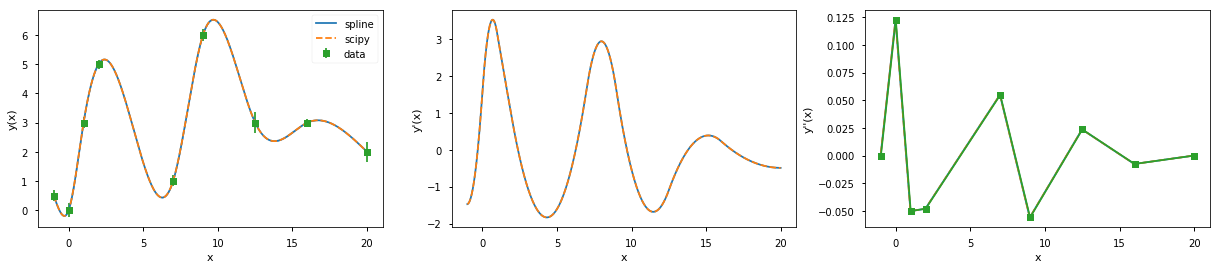

In [67]:
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
%matplotlib inline


# Input.
x = np.array([-1, 0, 1, 2, 7, 9, 12.5, 16, 20])
# x = np.array([-1, 0, 1, 2, 3, 4, 5, 6, 7])
y = np.array([0.5, 0, 3, 5, 1, 6, 3, 3, 2])
sig = np.array([0.2, 0.25, 0.175, 0.15, 0.19, 0.21, 0.35, 0.11, 0.35])


# Spline.
csu = CubicSplineUncertainty(x, y, sig)
x_spline = np.linspace(np.min(x), np.max(x), 1000)
y_spline, sig_spline = csu.interpolate(x_spline)

# Plot.
with plt.style.context('seaborn-notebook'):
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(21, 4)
    
    # spline.
    # -----------------------------------------------------------------------
    
    # cubic spline + uncertainty.
    line, = ax[0].plot(x_spline, y_spline, label='spline')
    ax[0].fill_between(x_spline, y_spline-sig_spline,  y_spline+sig_spline, alpha=0.5, color=line.get_color())
    
    # numpy solution.
    cs = CubicSpline(x, y, bc_type='natural')
    y_scipy = cs(x_spline)
    ax[0].plot(x_spline, y_scipy, linestyle='--', label='scipy')
    
    # input data (for comparison).
    ax[0].errorbar(x, y, sig, marker='s', linestyle='', label='data')
    
    ax[0].set_ylabel("y(x)")
    ax[0].legend()
    
    
    # first derivatives.
    # -----------------------------------------------------------------------
    ax[1].plot(x_spline[:-1], np.diff(y_spline)/np.diff(x_spline))
    ax[1].plot(x_spline[:-1], np.diff(y_scipy)/np.diff(x_spline), linestyle='--')
    ax[1].set_ylabel("y'(x)")
    
    
    # second derivatives.
    # -----------------------------------------------------------------------
    ax[2].plot(x_spline[:-2], np.diff(np.diff(y_spline)/np.diff(x_spline)))
    ax[2].plot(x_spline[:-2], np.diff(np.diff(y_scipy)/np.diff(x_spline)), linestyle='--')
    ax[2].plot(csu.x, csu.s*((np.max(x)-np.min(x))/1000), marker='s')
    ax[2].set_ylabel("y''(x)")
    
    
    # plot cosmetics.
    for a in ax:
        a.set_xlabel('x')
    